## Pneumonia X-ray image analysis

In [46]:
%matplotlib inline 
import os
import tensorflow as tf
import numpy as np
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, losses, metrics, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("tensorflow", tf.__version__)

tensorflow 2.18.0


In [47]:
# Training settings
batch_size = 128
img_height = 128
img_width = 128

## Data

In [48]:
train_dir = 'train'
test_dir = 'test'
# val_dir = 'chest_xray/val'

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 4616 files belonging to 2 classes.
Using 3693 files for training.
Found 4616 files belonging to 2 classes.
Using 923 files for validation.
Found 623 files belonging to 2 classes.


Seuraavassa blokissa haetaan kuvat alihakemistosta.

Funktio palauttaa:

train_label_count: luokkien lukumäärä
train_label_names: luokkien nimet
train_data: luetut kuvat listana matriiseina xdim*ydim
train_labels: numeroidut labelit listana


In [49]:
import cv2
import os
import glob
import gc

def lire_images(img_dir, xdim, ydim, nmax=5000) :
    """ 
    Lit les images dans les sous répertoires de img_dir
    nmax images lues dans chaque répertoire au maximum
    Renvoie :
    X : liste des images lues, matrices xdim*ydim
    y : liste des labels numériques
    label : nombre de labels
    label_names : liste des noms des répertoires lus
    """
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>nmax : break
            img = cv2.imread(f1) # Lecture de l'image dans le repertoire
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Conversion couleur RGB
            img = cv2.resize(img, (xdim,ydim)) # Redimensionnement de l'image
            X.append(np.array(img)) # Conversion en tableau et ajout a la liste des images
            y.append(label) # Ajout de l'etiquette de l'image a la liste des etiquettes
            n=n+1
        print(n,' images lues')
        label = label+1
    X = np.array(X)
    y = np.array(y)
    gc.collect() # Récupération de mémoire
    return X,y, label, label_names

# def lire_images(img_dir, xdim, ydim, nmax=5000) :
#     train_label_count = 0
#     train_label_names = []
#     train_data = []
#     train_labels=[]
#     for dirname in os.listdir(img_dir):
#         print(dirname)
#         train_label_names.append(dirname)
#         data_path = os.path.join(img_dir + "/" + dirname,'*g')
#         files = glob.glob(data_path)
#         n=0
#         for f1 in files:
#             if n>nmax : break
#             img = cv2.imread(f1)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
#             img = cv2.resize(img, (xdim,ydim)) 
#             train_data.append(np.array(img)) 
#             train_labels.append(train_label_count) 
#             n=n+1
#         print(n,' images')
#         train_label_count = train_label_count+1
#     train_data = np.array(train_data)
#     train_labels = np.array(train_labels)

#     return train_data,train_labels, train_label_count, train_label_names

In [50]:
# train_data,train_labels,label_count,label_names = lire_images("train", 128, 128, 2836) -- tämä vaihtoehto toimii myös / train_data = x, train_labels = y

In [51]:
X,y,Nombre_classes,Classes = lire_images("train", 128, 128, 2836)

NORMAL
1141  images lues
PNEUMONIA
2837  images lues


In [52]:
Classes

['NORMAL', 'PNEUMONIA']

In [53]:
Nombre_classes

2

In [54]:
X.shape

(3978, 128, 128, 3)

In [55]:
y.shape

(3978,)

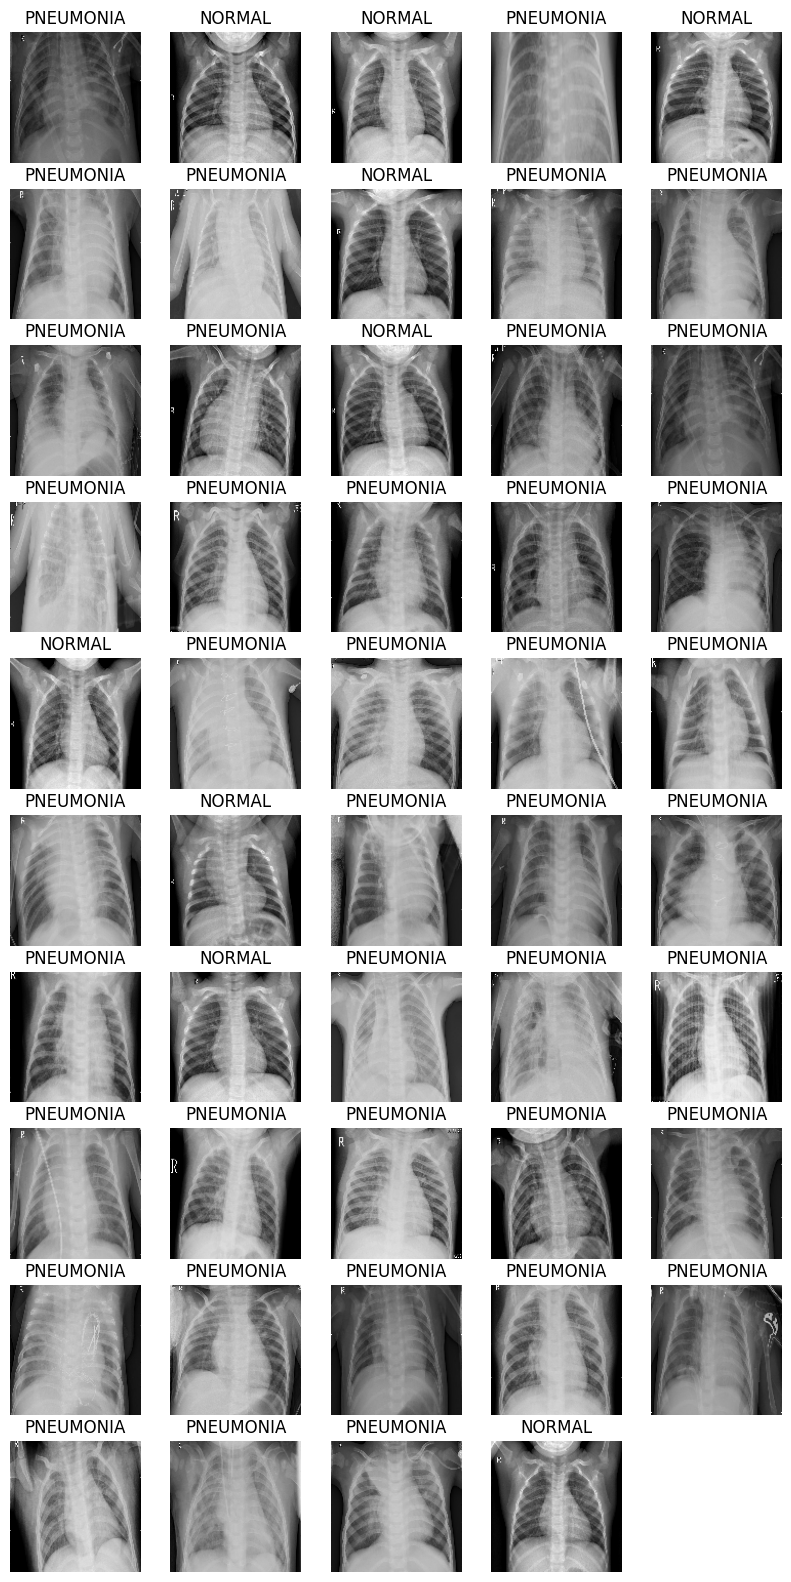

In [56]:
# plt.imshow(train_data[2118])

#kerttuli
# import random
# plt.figure(figsize=(10,20))
# for i in range(0,10) :
#     plt.subplot(10,5,i+1)
#     j = random.randint(0,len(train_data))
#     plt.axis('off')
#     plt.imshow(X[j])
#     plt.title(label_names[train_labels[j]])

#ranskal
import random
plt.figure(figsize=(10,20))
for i in range(0,49) :
    plt.subplot(10,5,i+1)
    j = random.randint(0,len(X))
    plt.axis('off')
    plt.imshow(X[j])
    plt.title(Classes[y[j]])

In [57]:
X.shape

(3978, 128, 128, 3)

In [58]:
# Normalisation entre 0 et 1
X = X / 255
print(X[0][0])

[[0.08627451 0.08627451 0.08627451]
 [0.07843137 0.07843137 0.07843137]
 [0.0627451  0.0627451  0.0627451 ]
 [0.19215686 0.19215686 0.19215686]
 [0.23529412 0.23529412 0.23529412]
 [0.27058824 0.27058824 0.27058824]
 [0.29019608 0.29019608 0.29019608]
 [0.3254902  0.3254902  0.3254902 ]
 [0.35294118 0.35294118 0.35294118]
 [0.35686275 0.35686275 0.35686275]
 [0.37647059 0.37647059 0.37647059]
 [0.39607843 0.39607843 0.39607843]
 [0.38823529 0.38823529 0.38823529]
 [0.40392157 0.40392157 0.40392157]
 [0.41960784 0.41960784 0.41960784]
 [0.43137255 0.43137255 0.43137255]
 [0.41568627 0.41568627 0.41568627]
 [0.6745098  0.6745098  0.6745098 ]
 [0.55686275 0.55686275 0.55686275]
 [0.54509804 0.54509804 0.54509804]
 [0.54117647 0.54117647 0.54117647]
 [0.75686275 0.75686275 0.75686275]
 [0.46666667 0.46666667 0.46666667]
 [0.43529412 0.43529412 0.43529412]
 [0.43921569 0.43921569 0.43921569]
 [0.42745098 0.42745098 0.42745098]
 [0.42352941 0.42352941 0.42352941]
 [0.40392157 0.40392157 0.40

In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

In [60]:
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical

On décompose en ensemble d'apprentissage et de validation :

In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [62]:
del X,y

On va utiliser utiliser une couche convolutionnelle pour l'extraction des caractéristiques, et une couche dense pour la classification :

In [63]:
# Réseau convolutionnel simple
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(128, 128, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(Nombre_classes, activation='softmax'))

# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

On peut afficher la structure du modèle :

In [64]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │       984,066 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986,498 (3.76 MB)

 Trainable params: 986,498 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Apprentissage
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.7437 - loss: 2.1860 - val_accuracy: 0.9196 - val_loss: 0.1984
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9619 - loss: 0.1061 - val_accuracy: 0.9447 - val_loss: 0.1555
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.9804 - loss: 0.0650 - val_accuracy: 0.9347 - val_loss: 0.1819
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9798 - loss: 0.0497 - val_accuracy: 0.9497 - val_loss: 0.1379
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9975 - loss: 0.0194 - val_accuracy: 0.9422 - val_loss: 0.1503
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.9986 - loss: 0.0105 - val_accuracy: 0.9573 - val_loss: 0.1450
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9994 - loss: 0.0083 - val_accuracy: 0.9523 - val_loss: 0.1466
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.9998 - loss: 0.0036 - 

In [66]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 95.23%


On définit une fonction pour afficher un graphique des scores :

In [67]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

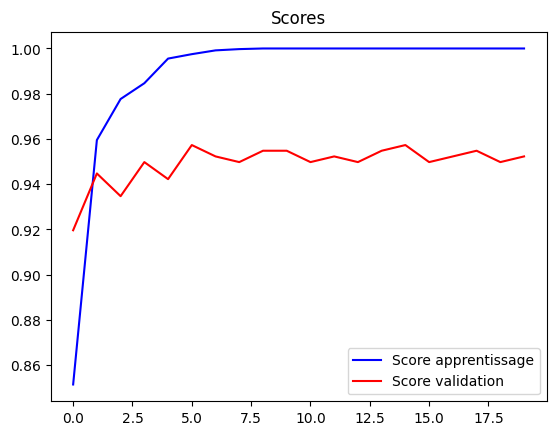

In [68]:
plot_scores(train)

La pertinence sur l'ensemble d'apprentissage est à 100%, mais ne dépasse pas 97% sur l'ensemble de validation ce qui est déjà un trés bon score.

In [69]:
# Prediction
y_cnn = np.argmax(model.predict(X_test),axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


on affiche 50 images où l'algorithme s'est trompé:

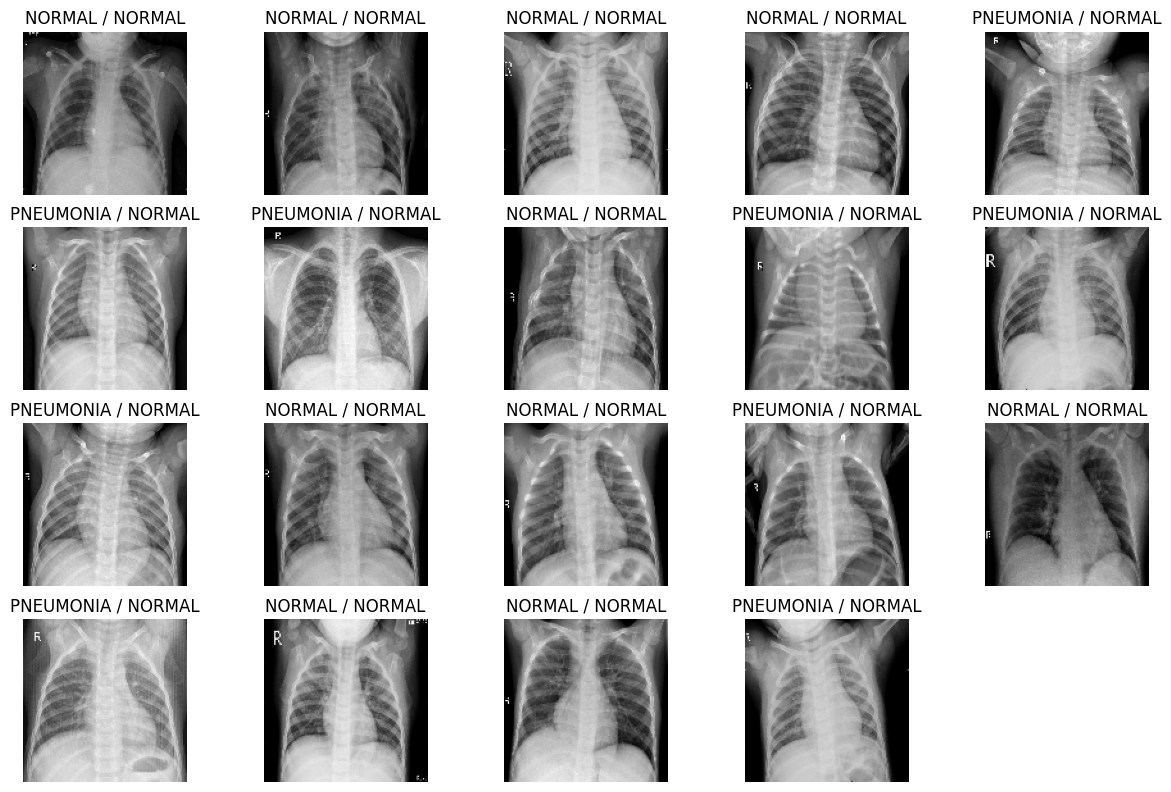

In [74]:
plt.figure(figsize=(15,25))
n_test = X_test.shape[0]
i=1
for j in range(len(X_test)) :
    if (y_cnn[j] != y_test[j]) & (i<50) :
        plt.subplot(10,5,i)
        plt.axis('off')
        plt.imshow(X_test[j])
        plt.title('%s / %s' % (Classes[y_cnn[j]], Classes[y_test[j].argmax(axis=-1)]))
        i+=1

Seulement 6 images ont mal été classifiées.

2 couches convolutionnelles¶

In [79]:
# Modèle CNN plus profond
modelx = Sequential()
modelx.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
modelx.add(MaxPooling2D(pool_size=(2, 2)))
modelx.add(Conv2D(20, (3, 3), activation='relu'))
modelx.add(MaxPooling2D(pool_size=(2, 2)))
modelx.add(Conv2D(20, (3, 3), activation='relu'))
modelx.add(MaxPooling2D(pool_size=(2, 2)))
modelx.add(Dropout(0.2))
modelx.add(Flatten())
modelx.add(Dense(Nombre_classes, activation='softmax'))

# Compilation du modèle
modelx.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

u:\Users\ok025980\Kuvat_ja_mallinnus\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
modelx.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 109, 109, 20)   │         5,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 52, 52, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 13520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │        27,042 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,338 (145.85 KB)

 Trainable params: 37,338 (145.85 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Apprentissage
train2 = modelx.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=1)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 13520, but received input with shape (None, 3920)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:


# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 13520, but received input with shape (None, 3920)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None